# Background

In 2018, the Center for Police Equity [released a report](https://www.berkeleyside.org/wp-content/uploads/2018/05/Berkeley-Report-May-2018.pdf) on the Berkeley Police Department saying that there were racial disparities in arrest rates between white and BIPOC subjects. Their study found that people of color were 4.5x-6.5x more likely to be stopped than white citizens, 4.5x-20x more likely to be searched per capita, and 2x as likely to be arrested overall. The report caused major discussion of polcing in the city of Berkeley, and one of the organizations requests was that the city collect more race specific data in their reports moving forward, particularly surrounding the *perceived* race of the subject and if their race had been perceived prior to the stop. 


Since the time of this report, the city has begun collecting [RIPA-compliant](https://ripalog.com/ripa/ripa-faq.htm#:~:text=RIPA%20stop%20data%3F-,What%20is%20RIPA%3F,regarding%20pedestrian%20and%20traffic%20stops%E2%80%9D.) stops data (September 2020 - Present) and very recently (Latest as of May 2022) approved a batch of [departmental and municipal changes](https://www.berkeleyside.org/2022/05/06/berkeley-city-council-approves-police-reimagining-package) that will radically alter how traffic stops are handled in the city of Berkeley. There is a unique opportunity here to conduct a more pointed analysis of stops and race, both in comparison to the broader non-RIPA stops data of the past, and before/in preparation for the very different data that will follow re-organization of Berkeley transportation laws and their enforcement. We will look to see if those specific racial disparities actually do exist with the better data, and set up opportunities for clear comparisons as future policies change. 

In this project notebook, we go through how we prepared our data, explored it, and used logistic regression modelling to analyze it. 

The questions we will show you how to answer in this notebook are: 
- Are Black, Hispanic, or BIPOC subjects more likely to be arrested than White Subjects when stopped? 
- Do local factors like neighborhood median income or residential racial composition affect likelihood of an arrest? 
- And do both the RIPA and Non-RIPA data reveal racial disparities? 

# Data Preperation

The data we'll be using for this project is in the "Data" section of the project folder, but is also available on the cities website. The more recent RIPA-compliant data is [here](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data-October-1-2020-Present-/ysvs-bcge), and the earlier [Non-RIPA](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data-Jan-26-2015-to-Sep-30-2020-/4tbf-3yt8) data is here.

For variables like local [median income](https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29&g=1400000US060014,06001421100,06001421200,06001421300,06001421400,06001421500,06001421600,06001421700,06001421800,06001421900,06001422000,06001422100,06001422200,06001422300,06001422400,06001422500,06001422600,06001422700,06001422800,06001422900,06001422901,06001422902,06001423000,06001423100,06001423200,06001423300,06001423400,06001423500,06001423601,06001423602,06001423700,06001423800,06001423901,06001423902,06001424001&tid=ACSST5Y2020.S1903) or [residential racial composition](https://data.census.gov/cedsci/table?t=Race%20and%20Ethnicity&g=1400000US060014,06001421100,06001421200,06001421300,06001421400,06001421500,06001421600,06001421700,06001421800,06001421900,06001422000,06001422100,06001422200,06001422300,06001422400,06001422500,06001422600,06001422700,06001422800,06001422900,06001422901,06001422902,06001423000,06001423100,06001423200,06001423300,06001423400,06001423500,06001423601,06001423602,06001423700,06001423800,06001423901,06001423902,06001424001&tid=ACSDT5Y2020.B02001), this data is also in the "Data" folder but can be customized and re-downloaded on the census website. A [census map of the city of Berkeley](https://data.cityofberkeley.info/Demographics/Census-Tract-Polygons-2010/peq3-2arw) is available on the city of Berkeley's website in multiple formats, and all maps created in this project are modified versions of the .geoJSON files available there. 

### Merging Stops Data

In [1]:
import glob
from pathlib import Path  
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point
import warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


First let's create the dataframes. 

In [2]:
non_ripa_df = pd.read_csv('Data/Berkeley_PD_-_Stop_Data__Jan_26__2015_to_Sep_30__2020_.csv',keep_default_na=True)
ripa_df = pd.read_csv('Data/Berkeley_PD_-_Stop_Data__October_1__2020_-_Present.csv',keep_default_na=True)

print(f'The non_RIPA dataframe has a shape of {non_ripa_df.shape}.')
non_ripa_df.columns

print(f'\nThe RIPA dataframe has a shape of {ripa_df.shape}.')
ripa_df.columns

The non_RIPA dataframe has a shape of (58951, 13).


Index(['CreateDatetime', 'IncidentNumber', 'Address', 'City', 'Lat', 'Lon',
       'CallType', 'Race', 'Gender', 'Age', 'Reason', 'Enforcement',
       'Car Search'],
      dtype='object')


The RIPA dataframe has a shape of (8454, 45).


Index(['LEA Record ID', 'Person Number', 'Date of Stop', 'Time of Stop',
       'Duration of Stop', 'Is Stop Made in Response to Call for Service',
       'Information Based Stop', 'Type Of Stop', 'Officer Type of Assignment',
       'Location', 'City', 'Is Location a K12 Public School',
       'If K12 School Is Stop of a Student', 'School Name',
       'Education Code Section', 'Education Code Subdivision',
       'Race Perceived Prior To Stop', 'Perceived Race or Ethnicity',
       'Perceived Gender', 'Perceived Gender Nonconforming', 'Is LGBT',
       'Perceived Age', 'Person had Limited or No English Fluency',
       'Perceived or Known Disability', 'City of Residence', 'Reason for Stop',
       'Reason for Stop Narrative', 'Traffic Violation Type',
       'Traffic Violation Offense Codes', 'Suspicion Offense Code',
       'Suspicion SubType', 'Actions Taken', 'Basis for Search',
       'Basis for Search Narrative', 'Basis for Property Seizure',
       'Type of Property Seized', 'C

Now let's format and join them. We'll remove any observations with innacurate location information, and change column names/values so that the two datasets can properly concatenate.

In [3]:
import warnings
warnings.filterwarnings("ignore")

ripa_df['Result of Stop'] = ripa_df['Result of Stop'].astype(str)

def relabel_result(i):
    cell = ripa_df['Result of Stop'][i]
    if cell in ('Citation for infraction'):
        return 'Citation'
    elif cell in ('Custodial arrest pursuant to outstanding warrant'):
        return 'Arrest'
    elif cell in ('Custodial arrest without warrant'):
        return 'Arrest'
    elif cell in ('Contacted parent/legal guardian or other person responsible for the minor'):
        return 'Contacted Parent/Legal Gaurdian'
    elif cell in ('Psychiatric hold (W&I Code 5150 or 5585.20)'):
        return 'Psychiatric Hold'
    elif cell in ('In-field cite and release'):
        return 'Citation'
    elif cell in ('Warning'):
        return 'Warning'
    elif cell in ('Warning (verbal or written)'):
        return 'Warning'
    elif cell in ('Field interview card completed'):
        return 'Field Interview Card Completed'
    elif cell in ('Noncriminal transport or caretaking transport (including transport by officer / ambulance or other agency)'):
        return 'Noncriminal Transport'
    elif cell in ('No action'):
        return 'No Action'
    else:
        return 'Other'
    
resultofstop = [relabel_result(i) for i in range(ripa_df.index.size)]
ripa_df['Result of Stop'] = resultofstop

non_ripa_df.rename(columns={'Enforcement':'Result of Stop'}, inplace=True)
non_ripa_df['Result of Stop'][non_ripa_df['Result of Stop']==0]='Other'


In [4]:
non_ripa_df['Type Of Stop'] = 'other'
non_ripa_df['Type Of Stop'][non_ripa_df['Reason'] == 'Traffic'] = 'Vehicle'

In [5]:
warnings.filterwarnings("default")

non_ripa_df.rename(columns={'Lat':'LAT', 
                            'Lon':'LONG',
                            'Race':'Perceived Race or Ethnicity',
                            'Gender':'Perceived Gender',
                            'Age':'Perceived Age',
                            'Reason':'Reason for Stop',
                            'Enforcement':'Result of Stop'}, inplace=True)

non_ripa_df['CreateDatetime'] = pd.to_datetime(non_ripa_df.CreateDatetime)
non_ripa_df['Date of Stop'] = non_ripa_df['CreateDatetime'].dt.date
non_ripa_df['Time of Stop'] = non_ripa_df['CreateDatetime'].dt.time
non_ripa_df = non_ripa_df.drop(columns = ['CreateDatetime'])



ripa_df = ripa_df[ripa_df.LONG != -361]
non_ripa_df = non_ripa_df[non_ripa_df.LONG != -361]
print(f'The non_RIPA dataframe has a shape of {non_ripa_df.shape}.')
print(f'The RIPA dataframe has a shape of {ripa_df.shape}.')
print(f'The two dataframes have {len(np.intersect1d(non_ripa_df.columns, ripa_df.columns))} shared columns,\n\n{np.intersect1d(non_ripa_df.columns, ripa_df.columns)}')

The non_RIPA dataframe has a shape of (55976, 15).
The RIPA dataframe has a shape of (8454, 45).
The two dataframes have 11 shared columns,

['City' 'Date of Stop' 'LAT' 'LONG' 'Perceived Age' 'Perceived Gender'
 'Perceived Race or Ethnicity' 'Reason for Stop' 'Result of Stop'
 'Time of Stop' 'Type Of Stop']


Here we'll label age values with ranges. Because this is considered a continuous variable in our models, rough averages as replacements should not affect the variables significance very much, if at all. 

In [6]:
warnings.filterwarnings("ignore")

all_stops = pd.concat([ripa_df,non_ripa_df], axis=0)

all_stops['Perceived Age'][all_stops['Perceived Age'] == '>40'] = 47
all_stops['Perceived Age'][all_stops['Perceived Age'] == '30-39'] = 35
all_stops['Perceived Age'][all_stops['Perceived Age'] == '18-29'] = 25
all_stops['Perceived Age'][all_stops['Perceived Age'] == '<18'] = 15
all_stops['Perceived Age'][all_stops['Perceived Age'] == '<18'] = 15
all_stops['Perceived Age'][all_stops['Perceived Age'].isnull()] = 18
all_stops['Perceived Age'][all_stops['Perceived Age'] == '0'] = 18

In [7]:
all_stops['Type Of Stop'].value_counts()

Vehicle       51974
other          8841
Pedestrian     3468
Bicycle         146
Name: Type Of Stop, dtype: int64

In [8]:
all_stops.shape
all_stops.head(3)
all_stops.columns

(64430, 49)

,LEA Record ID,Person Number,Date of Stop,Time of Stop,Duration of Stop,Is Stop Made in Response to Call for Service,Information Based Stop,Type Of Stop,Officer Type of Assignment,Location,...,Citation Offense Codes,Result of Stop,In field cite and release Offense Codes,Custodial arrest Offense Codes,LAT,LONG,IncidentNumber,Address,CallType,Car Search
0,BPD000021033,1.0,10/1/2020,11:14,8.0,False,NaN,Vehicle,"Patrol, traffic enforcement, field operations",2900 block of Shattuck Ave,...,VC 23123(A) USE CELLPH W/DRIV W/O HFD (I) | VC...,Citation,NaN,NaN,37.855313,-122.266571,NaN,NaN,NaN,NaN
1,BPD000021032,2.0,10/1/2020,9:40,15.0,True,NaN,Pedestrian,"Patrol, traffic enforcement, field operations",3000 block of San Pablo Ave,...,NaN,Warning,NaN,NaN,37.851856,-122.286553,NaN,NaN,NaN,NaN
2,BPD000021035,1.0,10/1/2020,14:32,60.0,True,NaN,Pedestrian,"Patrol, traffic enforcement, field operations",2000 block of 10th St,...,NaN,Arrest,NaN,PC 484 THEFT (M) | VC 10852 TAMPER WITH VEHICL...,37.868619,-122.293213,NaN,NaN,NaN,NaN


Index(['LEA Record ID', 'Person Number', 'Date of Stop', 'Time of Stop',
       'Duration of Stop', 'Is Stop Made in Response to Call for Service',
       'Information Based Stop', 'Type Of Stop', 'Officer Type of Assignment',
       'Location', 'City', 'Is Location a K12 Public School',
       'If K12 School Is Stop of a Student', 'School Name',
       'Education Code Section', 'Education Code Subdivision',
       'Race Perceived Prior To Stop', 'Perceived Race or Ethnicity',
       'Perceived Gender', 'Perceived Gender Nonconforming', 'Is LGBT',
       'Perceived Age', 'Person had Limited or No English Fluency',
       'Perceived or Known Disability', 'City of Residence', 'Reason for Stop',
       'Reason for Stop Narrative', 'Traffic Violation Type',
       'Traffic Violation Offense Codes', 'Suspicion Offense Code',
       'Suspicion SubType', 'Actions Taken', 'Basis for Search',
       'Basis for Search Narrative', 'Basis for Property Seizure',
       'Type of Property Seized', 'C

In [9]:
all_stops.to_csv('Exports/Merged Stops Data.csv')

In [10]:
all_stops['Result of Stop'].isna().sum()

0

### Merging the Expanded Dataframe with Census Data

Alright, great! Now let's find the census tract for each stop. This will be useful later when we merge this data with census data. We'll be checking to see if the latitude and longitude points fall within the map geometries provided by our .geojson file, and if they do, putting in the tract number they fall within.

In [11]:
berkeley = geopandas.read_file('Data/Census Tract Polygons 2010.geojson')
all_stops = pd.read_csv('Exports/Merged Stops Data.csv')

In [12]:
%%time

stop_point = [Point(all_stops['LONG'][i], all_stops['LAT'][i]) for i in np.arange(len(all_stops))]
tt = [berkeley['geometry'].contains(stop_point[i]) for i in np.arange(len(stop_point))]
judge = [np.where(tt[i] == True)[0] for i in np.arange(len(tt))]
tract_column = [i[0] if i.size > 0  else -1 for i in judge]
all_stops['tract'] = tract_column
berkeley['order'] = np.arange(len(berkeley))
df = all_stops.merge(berkeley[['name10', 'order']], left_on = 'tract', right_on = 'order')
df.drop(columns=['tract','order'], inplace=True)
df.rename(columns={"name10":"Census Tract"}, inplace=True)

CPU times: user 22.1 s, sys: 326 ms, total: 22.4 s
Wall time: 22.4 s


In [13]:
all_stops.isna().sum()
all_stops['Result of Stop'].isna().sum()

Unnamed: 0                                          0
LEA Record ID                                   55977
Person Number                                   55977
Date of Stop                                        1
Time of Stop                                        1
Duration of Stop                                55977
Is Stop Made in Response to Call for Service    55977
Information Based Stop                          59854
Type Of Stop                                        1
Officer Type of Assignment                      55977
Location                                        55977
City                                              711
Is Location a K12 Public School                 55977
If K12 School Is Stop of a Student              64414
School Name                                     64414
Education Code Section                          64430
Education Code Subdivision                      64430
Race Perceived Prior To Stop                    55977
Perceived Race or Ethnicity 

0

We'll upload, re-label, and merge the census data here before merging it with the larger dataframe. 

In [14]:
race_data = pd.read_csv('Data/Berkeley Census Tract Race Data 2020.csv')
race_data.rename(columns = {'Total Pop':'tract_totalpop',
                            'White alone':'tract_whitepop',
                            'Black or African American alone':'tract_aapop',
                            'American Indian and Alaska Native alone':'tract_na_aipop',
                            'Asian alone':'tract_asianpop',
                            'Native Hawaiian and Other Pacific Islander alone':'tract_hawaiianpop'},inplace=True)

tract_mixed2 = [race_data['Some other race alone'][i] + race_data['Two or more races:'][i] + race_data['Three or More/ Other'][i] for i in range(race_data.index.size)]
race_data['tract_mixed2'] = tract_mixed2
race_data.drop(columns=['Some other race alone','Two or more races:','Three or More/ Other'], inplace=True)



race_data = race_data.replace(',','', regex=True)
race_data.iloc[:,:1], race_data.iloc[:,1:] = race_data.iloc[:,:1].astype(float),race_data.iloc[:,1:].astype(int)
tract_bipoccomp = [(race_data['tract_aapop'][i] + race_data['tract_na_aipop'][i] + race_data['tract_asianpop'][i] + race_data['tract_hawaiianpop'][i] + race_data['tract_mixed2'][i])/race_data['tract_totalpop'][i] for i in range(race_data.index.size)]
race_data['tract_bipoccomp'] = tract_bipoccomp



median_income_data = pd.read_csv('Data/Berkeley Census Tract Median Income Data 2020 (Simplified).csv')
median_income_data.rename(columns = {'household_income':'tract_medianincome'},inplace=True)


census_data = pd.merge(race_data, median_income_data,on="Tract")
census_data.rename(columns={'household_income':'Median Household Income',
                            'Tract':'Census Tract'}, inplace=True)

print(census_data.columns)

Index(['Census Tract', 'tract_totalpop', 'tract_whitepop', 'tract_aapop',
       'tract_na_aipop', 'tract_asianpop', 'tract_hawaiianpop', 'tract_mixed2',
       'tract_bipoccomp', 'tract_medianincome'],
      dtype='object')


We'll also take a second here to count the average number of annual stops for each census tract, as well as the distance of each tract from the university. 

In [15]:
tracts = df['Census Tract'].unique()
count_tracts = []
counts = []

for tract in tracts:
    table = df[df['Census Tract'] == tract]
    average_count = round((table.shape[0])/8,2)
    count_tracts.append(tract)
    counts.append(average_count)

d = {'Census Tract':count_tracts, 'tract_annualstops':counts}
counts_table = pd.DataFrame(data=d)
counts_table['Census Tract'] = counts_table['Census Tract'].astype(float)
counts_table.head()

,Census Tract,tract_annualstops
0,4235.00,435.75
1,4240.02,213.12
2,4232.00,168.00
3,4228.00,425.88
4,4238.00,92.38


In [16]:
from geopy.distance import geodesic

uni_coords = (37.8719,122.2585)
berkeley['intptlat10'],berkeley['intptlon10'] = berkeley['intptlat10'].astype(float),berkeley['intptlon10'].astype(float)*-1

counts_distances = [round(geodesic([ berkeley['intptlat10'][i],berkeley['intptlon10'][i] ],uni_coords).miles,2) for i in range(berkeley.index.size)]
berkeley['tract_distancefromcal'] = counts_distances
distances_table = berkeley[['name10','tract_distancefromcal']].rename(columns={'name10':'Census Tract'})
distances_table['Census Tract'] = distances_table['Census Tract'].astype(float)
distances_table.head()

,Census Tract,tract_distancefromcal
0,4238.0,1.42
1,4222.0,1.60
2,4224.0,0.65
3,4225.0,0.39
4,4223.0,1.07


In [17]:
df['Census Tract'] = df['Census Tract'].astype(float)
df_expanded = pd.merge(df, census_data, how="left", left_on="Census Tract", right_on="Census Tract")
df_expanded = pd.merge(df_expanded, counts_table, how="left", left_on="Census Tract", right_on="Census Tract")
df_expanded = pd.merge(df_expanded, distances_table, how="left", left_on="Census Tract", right_on="Census Tract")
df_expanded = df_expanded.iloc[:,1:]

In [18]:
df_expanded['Type Of Stop'].isna().sum()

0

And now we can drop columns that aren't used in the analysis or EDA, remove values that are NAN because of insufficient data, and re-label. 

In [19]:
df_expanded['tract_totalpop'][df_expanded['Census Tract'] == 4240.02] = 2172
df_expanded['tract_whitepop'][df_expanded['Census Tract'] == 4240.02] = 862
df_expanded['tract_aapop'][df_expanded['Census Tract'] == 4240.02] = 899
df_expanded['tract_na_aipop'][df_expanded['Census Tract'] == 4240.02] = 14
df_expanded['tract_asianpop'][df_expanded['Census Tract'] == 4240.02] = 242
df_expanded['tract_hawaiianpop'][df_expanded['Census Tract'] == 4240.02] = 0
df_expanded['tract_mixed2'][df_expanded['Census Tract'] == 4240.02] = 217
df_expanded['tract_medianincome'][df_expanded['Census Tract'] == 4240.02] = 87321
df_expanded['tract_annualstops'][df_expanded['Census Tract'] == 4240.02] = 119
df_expanded['tract_distancefromcal'][df_expanded['Census Tract'] == 4240.02] = 1.9
df_expanded['tract_bipoccomp'][df_expanded['Census Tract'] == 4240.02] = round((899+14+242+0+217)/2172,2)

df_expanded['tract_totalpop'][df_expanded['Census Tract'] == 4229] = 2627
df_expanded['tract_whitepop'][df_expanded['Census Tract'] == 4229] = 1006
df_expanded['tract_aapop'][df_expanded['Census Tract'] == 4229] = 25
df_expanded['tract_na_aipop'][df_expanded['Census Tract'] == 4229] = 0
df_expanded['tract_asianpop'][df_expanded['Census Tract'] == 4229] = 1371
df_expanded['tract_hawaiianpop'][df_expanded['Census Tract'] == 4229] = 106
df_expanded['tract_mixed2'][df_expanded['Census Tract'] == 4229] = 178
df_expanded['tract_medianincome'][df_expanded['Census Tract'] == 4229] = 44933
df_expanded['tract_annualstops'][df_expanded['Census Tract'] == 4229] = 221
df_expanded['tract_distancefromcal'][df_expanded['Census Tract'] == 4229] = .15
df_expanded['tract_bipoccomp'][df_expanded['Census Tract'] == 4229] = 0.64

df_expanded['tract_totalpop'][df_expanded['Census Tract'] == 4226] = 1215
df_expanded['tract_whitepop'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_whitepop'].mean()
df_expanded['tract_aapop'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_aapop'].mean()
df_expanded['tract_na_aipop'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_na_aipop'].mean()
df_expanded['tract_asianpop'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_asianpop'].mean()
df_expanded['tract_hawaiianpop'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_hawaiianpop'].mean()
df_expanded['tract_mixed2'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_mixed2'].mean()
df_expanded['tract_medianincome'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_medianincome'].mean()
df_expanded['tract_annualstops'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_annualstops'].mean()
df_expanded['tract_distancefromcal'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_distancefromcal'].mean()
df_expanded['tract_bipoccomp'][df_expanded['Census Tract'] == 4226] = df_expanded['tract_bipoccomp'].mean()



In [20]:
df_expanded.drop(columns=['LEA Record ID', 'Person Number', 'Date of Stop', 'Time of Stop',
                         'Is Stop Made in Response to Call for Service','Information Based Stop','Officer Type of Assignment',
       'Location', 'City', 'Is Location a K12 Public School',
       'If K12 School Is Stop of a Student', 'School Name',
       'Education Code Section', 'Education Code Subdivision','Perceived Gender Nonconforming', 'Is LGBT',
                          'Person had Limited or No English Fluency',
       'Perceived or Known Disability', 'City of Residence','Traffic Violation Type',
       'Traffic Violation Offense Codes', 'Suspicion Offense Code',
       'Suspicion SubType', 'Actions Taken', 'Basis for Search',
       'Basis for Search Narrative', 'Basis for Property Seizure',
       'Type of Property Seized', 'Contraband or Evidence',
       'Other Contraband Desc', 'Warning Offense Codes',
       'Citation Offense Codes','In field cite and release Offense Codes',
       'Custodial arrest Offense Codes','IncidentNumber',
       'Address', 'CallType', 'Car Search',
                         ],inplace=True)
df_expanded.columns

Index(['Duration of Stop', 'Type Of Stop', 'Race Perceived Prior To Stop',
       'Perceived Race or Ethnicity', 'Perceived Gender', 'Perceived Age',
       'Reason for Stop', 'Reason for Stop Narrative', 'Result of Stop', 'LAT',
       'LONG', 'Census Tract', 'tract_totalpop', 'tract_whitepop',
       'tract_aapop', 'tract_na_aipop', 'tract_asianpop', 'tract_hawaiianpop',
       'tract_mixed2', 'tract_bipoccomp', 'tract_medianincome',
       'tract_annualstops', 'tract_distancefromcal'],
      dtype='object')

In [21]:
df_expanded['Result of Stop'].isna().sum()
df_expanded.isna().sum()

0

Duration of Stop                53612
Type Of Stop                        0
Race Perceived Prior To Stop    53612
Perceived Race or Ethnicity         0
Perceived Gender                    2
Perceived Age                       0
Reason for Stop                     4
Reason for Stop Narrative       53612
Result of Stop                      0
LAT                                 0
LONG                                0
Census Tract                        0
tract_totalpop                      0
tract_whitepop                      0
tract_aapop                         0
tract_na_aipop                      0
tract_asianpop                      0
tract_hawaiianpop                   0
tract_mixed2                        0
tract_bipoccomp                     0
tract_medianincome                  0
tract_annualstops                   0
tract_distancefromcal               0
dtype: int64

Great! We now have a fully expanded dataset. Before we export, let's quickly merge our newly organized census data with the RIPA dataset as well. Then, we'll save our new processed dataframes to .csv files in our exports folder.

In [22]:
census_data = pd.merge(census_data, counts_table, how="left", left_on="Census Tract", right_on="Census Tract")
census_data = pd.merge(census_data, distances_table, how="left", left_on="Census Tract", right_on="Census Tract")

In [23]:
census_data.loc[18,'tract_medianincome'] = census_data.loc[17,'tract_medianincome'] #this is the cell from the other half of this tract (.01)
census_data.loc[[17,18],'tract_annualstops'] = census_data['tract_annualstops'].mean() 
census_data.loc[[17,18],'tract_distancefromcal'] = .15 #we can tell this tract is .15 miles from campus by viewing the map
census_data.head(3)

,Census Tract,tract_totalpop,tract_whitepop,tract_aapop,tract_na_aipop,tract_asianpop,tract_hawaiianpop,tract_mixed2,tract_bipoccomp,tract_medianincome,tract_annualstops,tract_distancefromcal
0,4211.0,2146,1853,41,0,182,9,117,0.162628,206199.0,13.88,1.94
1,4212.0,3690,2504,34,4,701,0,850,0.430623,198576.0,25.25,1.99
2,4213.0,4070,3204,58,6,388,4,747,0.295577,152679.0,35.00,1.82


In [24]:
%%time

ripa_df_expanded = ripa_df.copy()

stop_point = [Point(ripa_df_expanded['LONG'][i], ripa_df_expanded['LAT'][i]) for i in np.arange(len(ripa_df_expanded))]
tt = [berkeley['geometry'].contains(stop_point[i]) for i in np.arange(len(stop_point))]
judge = [np.where(tt[i] == True)[0] for i in np.arange(len(tt))]
tract_column = [i[0] if i.size > 0  else -1 for i in judge]
ripa_df_expanded['tract'] = tract_column
berkeley['order'] = np.arange(len(berkeley))
ripa_df_expanded = ripa_df_expanded.merge(berkeley[['name10', 'order']], left_on = 'tract', right_on = 'order')
ripa_df_expanded.drop(columns=['tract','order'], inplace=True)
ripa_df_expanded.rename(columns={"name10":"Census Tract"}, inplace=True)
ripa_df_expanded = ripa_df_expanded.iloc[:,1:]
ripa_df_expanded['Census Tract'] = ripa_df_expanded['Census Tract'].astype(float)
ripa_df_expanded.shape

ripa_df_expanded = pd.merge(ripa_df_expanded, census_data, how="left", left_on="Census Tract", right_on="Census Tract")

CPU times: user 3.18 s, sys: 31.9 ms, total: 3.21 s
Wall time: 3.21 s


For simplicity sake, we're going to hardcode some of the ripa_df census data here. Because some of the census tract numbers are split in half (.01 and .02), their information gets lost when merged with the stops datasets. 

In [25]:
ripa_df_expanded['tract_totalpop'][ripa_df_expanded['Census Tract'] == 4240.02] = 2172
ripa_df_expanded['tract_whitepop'][ripa_df_expanded['Census Tract'] == 4240.02] = 862
ripa_df_expanded['tract_aapop'][ripa_df_expanded['Census Tract'] == 4240.02] = 899
ripa_df_expanded['tract_na_aipop'][ripa_df_expanded['Census Tract'] == 4240.02] = 14
ripa_df_expanded['tract_asianpop'][ripa_df_expanded['Census Tract'] == 4240.02] = 242
ripa_df_expanded['tract_hawaiianpop'][ripa_df_expanded['Census Tract'] == 4240.02] = 0
ripa_df_expanded['tract_mixed2'][ripa_df_expanded['Census Tract'] == 4240.02] = 217
ripa_df_expanded['tract_medianincome'][ripa_df_expanded['Census Tract'] == 4240.02] = 87321
ripa_df_expanded['tract_annualstops'][ripa_df_expanded['Census Tract'] == 4240.02] = 119
ripa_df_expanded['tract_distancefromcal'][ripa_df_expanded['Census Tract'] == 4240.02] = 1.9
ripa_df_expanded['tract_bipoccomp'][ripa_df_expanded['Census Tract'] == 4240.02] = round((899+14+242+0+217)/2172,2)

ripa_df_expanded['tract_totalpop'][ripa_df_expanded['Census Tract'] == 4229] = 2627
ripa_df_expanded['tract_whitepop'][ripa_df_expanded['Census Tract'] == 4229] = 1006
ripa_df_expanded['tract_aapop'][ripa_df_expanded['Census Tract'] == 4229] = 25
ripa_df_expanded['tract_na_aipop'][ripa_df_expanded['Census Tract'] == 4229] = 0
ripa_df_expanded['tract_asianpop'][ripa_df_expanded['Census Tract'] == 4229] = 1371
ripa_df_expanded['tract_hawaiianpop'][ripa_df_expanded['Census Tract'] == 4229] = 106
ripa_df_expanded['tract_mixed2'][ripa_df_expanded['Census Tract'] == 4229] = 178
ripa_df_expanded['tract_medianincome'][ripa_df_expanded['Census Tract'] == 4229] = 44933
ripa_df_expanded['tract_annualstops'][ripa_df_expanded['Census Tract'] == 4229] = 221
ripa_df_expanded['tract_distancefromcal'][ripa_df_expanded['Census Tract'] == 4229] = .15
ripa_df_expanded['tract_bipoccomp'][ripa_df_expanded['Census Tract'] == 4229] = 0.64

ripa_df_expanded['tract_totalpop'][ripa_df_expanded['Census Tract'] == 4226] = 1215
ripa_df_expanded['tract_whitepop'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_whitepop'].mean()
ripa_df_expanded['tract_aapop'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_aapop'].mean()
ripa_df_expanded['tract_na_aipop'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_na_aipop'].mean()
ripa_df_expanded['tract_asianpop'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_asianpop'].mean()
ripa_df_expanded['tract_hawaiianpop'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_hawaiianpop'].mean()
ripa_df_expanded['tract_mixed2'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_mixed2'].mean()
ripa_df_expanded['tract_medianincome'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_medianincome'].mean()
ripa_df_expanded['tract_annualstops'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_annualstops'].mean()
ripa_df_expanded['tract_distancefromcal'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_distancefromcal'].mean()
ripa_df_expanded['tract_bipoccomp'][ripa_df_expanded['Census Tract'] == 4226] = ripa_df_expanded['tract_bipoccomp'].mean()

In [26]:
ripa_df_expanded.drop(columns=['Person Number', 'Date of Stop', 'Time of Stop', 'Is Stop Made in Response to Call for Service',
       'Information Based Stop','Officer Type of Assignment',
       'Location', 'City', 'Is Location a K12 Public School',
       'If K12 School Is Stop of a Student', 'School Name',
       'Education Code Section', 'Education Code Subdivision','Perceived Gender Nonconforming', 'Is LGBT','Person had Limited or No English Fluency',
       'Perceived or Known Disability', 'City of Residence','Reason for Stop Narrative', 'Traffic Violation Type',
       'Traffic Violation Offense Codes', 'Suspicion Offense Code',
       'Suspicion SubType', 'Actions Taken', 'Basis for Search',
       'Basis for Search Narrative', 'Basis for Property Seizure','Type of Property Seized', 'Contraband or Evidence',
       'Other Contraband Desc', 'Warning Offense Codes',
       'Citation Offense Codes', 'In field cite and release Offense Codes',
       'Custodial arrest Offense Codes',
                         ],inplace=True)

ripa_df_expanded.columns

Index(['Duration of Stop', 'Type Of Stop', 'Race Perceived Prior To Stop',
       'Perceived Race or Ethnicity', 'Perceived Gender', 'Perceived Age',
       'Reason for Stop', 'Result of Stop', 'LAT', 'LONG', 'Census Tract',
       'tract_totalpop', 'tract_whitepop', 'tract_aapop', 'tract_na_aipop',
       'tract_asianpop', 'tract_hawaiianpop', 'tract_mixed2',
       'tract_bipoccomp', 'tract_medianincome', 'tract_annualstops',
       'tract_distancefromcal'],
      dtype='object')

In [27]:
ripa_df_expanded['Result of Stop'].isna().sum()
ripa_df_expanded.isna().sum()

0

Duration of Stop                0
Type Of Stop                    0
Race Perceived Prior To Stop    0
Perceived Race or Ethnicity     0
Perceived Gender                2
Perceived Age                   0
Reason for Stop                 0
Result of Stop                  0
LAT                             0
LONG                            0
Census Tract                    0
tract_totalpop                  0
tract_whitepop                  0
tract_aapop                     0
tract_na_aipop                  0
tract_asianpop                  0
tract_hawaiianpop               0
tract_mixed2                    0
tract_bipoccomp                 0
tract_medianincome              0
tract_annualstops               0
tract_distancefromcal           0
dtype: int64

In [28]:
df_expanded.to_csv('Exports/Large Dataset (with census data).csv')
ripa_df_expanded.to_csv('Exports/Small Dataset (with census data).csv')
census_data.to_csv('Exports/Census Data Expanded.csv')

In [29]:
berkeley['name10'] = berkeley['name10'].astype(float)
new_berkeley_geojson = pd.merge(berkeley, census_data, left_on='name10',right_on='Census Tract')

In [30]:
new_berkeley_geojson.to_file("Exports/Census Tract Polygons 2010 (EXPANDED).geojson", driver='GeoJSON')

# Exploratory Data Analysis

Now that we have our prepared data, let's explore it and try to get an idea of what we're looking at! Below we'll create some bar/pie charts, boxplots, and also use folium to create some interactive maps. Let's start by creating charts to look at the most common kinds of stops and results of stops. 

In [31]:
import matplotlib.pyplot as plt
import json
import os

# Force display of all values 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [32]:
df = df_expanded

([<matplotlib.patches.Wedge at 0x7f05a1bf4af0>,
 [Text(-0.9678052714822675, 0.5228316712777975, 'Vehicle'),
  Text(1.0373517147517568, -0.6032424221667356, 'Pedestrian'),
  Text(1.0994572512020042, -0.0345507276237868, 'Bicycle')],
 [Text(-0.5278937844448731, 0.28518091160607134, '84.2%'),
  Text(0.6051218336051913, -0.3518914129305958, '14.8%'),
  Text(0.5997039552010932, -0.018845851431156434, '1.0%')])

(-1.1090501382776972,
 1.1889263066434868,
 -1.106244188990592,
 1.106292965803434)

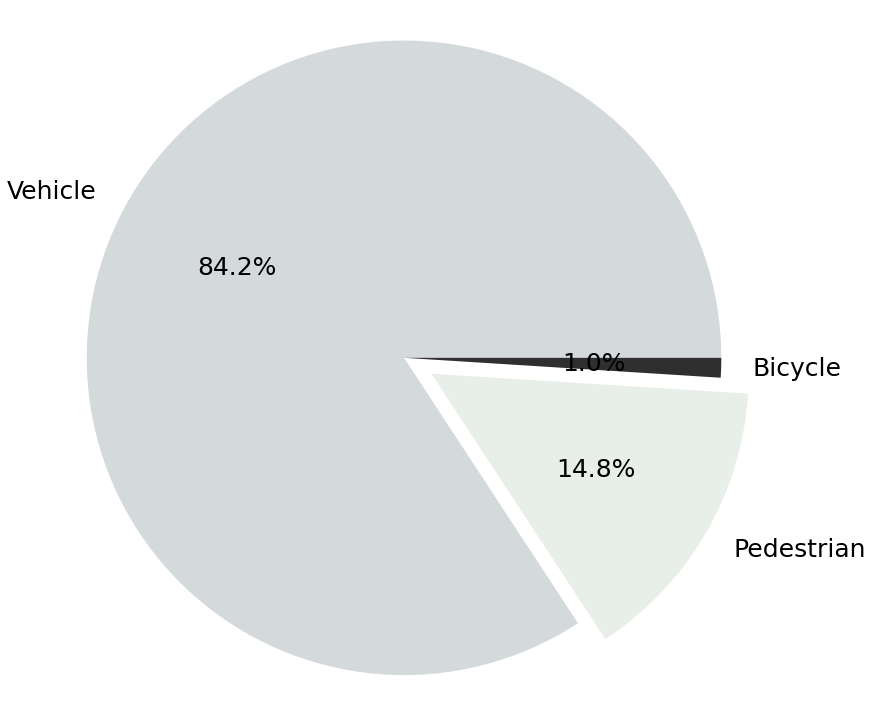

In [33]:
plt.rc('font', size=25)


# Pie chart
labels = ['Vehicle', 'Pedestrian', 'Bicycle']
counts = []
traffic_counts = non_ripa_df['Reason for Stop'].value_counts()[0] + ripa_df['Type Of Stop'].value_counts()[0]
est_bike_stops = round((.01*len(df.index)))
est_pedestrian_stops = round((len(df.index)) - traffic_counts - est_bike_stops)

counts.append(traffic_counts)
counts.append(est_pedestrian_stops)
counts.append(est_bike_stops)
# only "explode" the 2nd slice (i.e. 'traffic')

explode = (0, 0.1, 0)  
fig1, ax1 = plt.subplots()
colors= ['#D4DADC', '#E7EFE8', '#2F2F2F']



ax1.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',colors=colors)

ax1.axis('equal')  
plt.tight_layout()

figure = plt.gcf()
figure.set_size_inches(16, 12)
plt.savefig('Exports/Types of Stops pie')
plt.show()

In [34]:
%%time
import warnings
warnings.filterwarnings("ignore")

def relabel_result(i):
    cell = df['Result of Stop'][i]
    if cell in ('Citation for infraction'):
        return 'Citation'
    elif cell in ('Custodial arrest pursuant to outstanding warrant'):
        return 'Custodial Arrest with Warrant'
    elif cell in ('Custodial arrest without warrant'):
        return 'Custodial Arrest without Warrant'
    elif cell in ('Contacted parent/legal guardian or other person responsible for the minor'):
        return 'Contacted Parent/Legal Gaurdian'
    elif cell in ('Psychiatric hold (W&I Code 5150 or 5585.20)'):
        return 'Psychiatric Hold'
    elif cell in ('In-field cite and release'):
        return 'Citation'
    elif cell in ('Warning'):
        return 'Warning'
    elif cell in ('Warning (verbal or written)'):
        return 'Warning'
    elif cell in ('Field interview card completed'):
        return 'Field Interview Card Completed'
    elif cell in ('Noncriminal transport or caretaking transport (including transport by officer / ambulance or other agency)'):
        return 'Noncriminal Transport'
    elif cell in ('No action'):
        return 'No Action'


resultofstop = [relabel_result(i) for i in range(df.index.size)]
df['resultofstop'] = resultofstop
df.drop(columns=['Result of Stop'], inplace=True)


types_grouped = df.groupby('resultofstop',as_index=False).count()
types_grouped = types_grouped[['resultofstop','LAT']].rename(columns={'LAT':'count'})
types_grouped.sort_values(by='count', ascending=True, inplace=True, ignore_index=True)
types_grouped

CPU times: user 448 ms, sys: 5.85 ms, total: 454 ms
Wall time: 452 ms


,resultofstop,count
0,Psychiatric Hold,334
1,Citation,21084
2,Warning,34476


Text(0, 0.5, '')

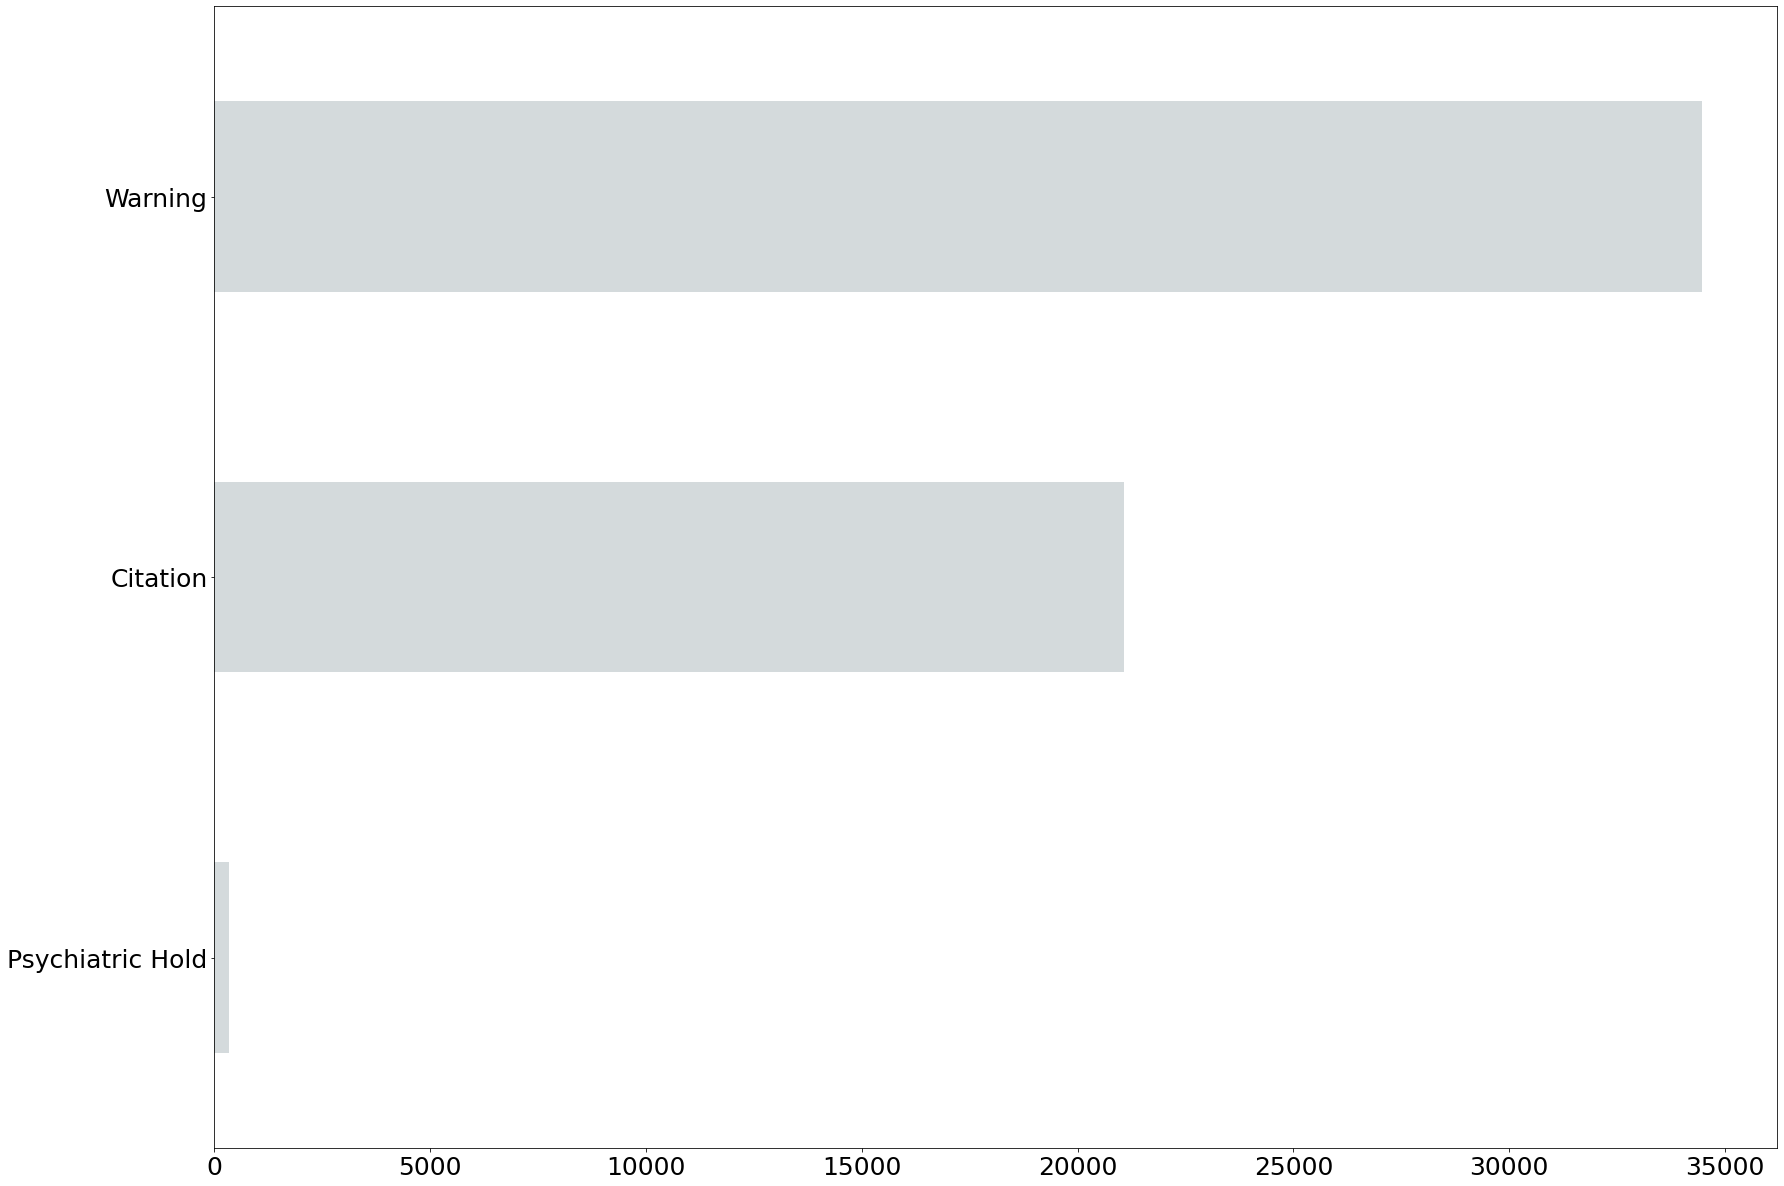

In [35]:
plt.rc('font', size=25)

types_grouped_chart = types_grouped.plot.barh(x='resultofstop', y='count', color='#D4DADC', legend=False)
types_grouped_chart.yaxis.set_label_text("")
figure = plt.gcf()
figure.set_size_inches(28, 21)
plt.savefig('Exports/Stop Result Types Bar Chart.png')
plt.show()

So far it's looking like the majority of stops in this dataset are traffic stops, and that most of them result in either Warnings, Citations, or nothing at all. Arrests make up less than 2% of all stops. This is a good reminder that we're not looking at holistic crime data, but specifically at stops. It also helps us determine how we should build our test scenario in later modelling.  

In the meantime, let's start trying to look at racial disparities, and get a visual representation of the stops as well. We'll start with an arrests by racial group bar chart below. 

In [36]:
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 'White'] = 2
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 'Black/African American'] = 3
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] ==  'Black'] = 3
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity']=="Hispanic/Latino"] = 4 
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity']=="Hispanic"] = 4
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 'Asian'] = 5
df['Perceived Race or Ethnicity'][~df['Perceived Race or Ethnicity'].isin([2,3,4,5])] = 1


df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 1] = 'Mixed/Other'
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 2] = 'White'
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 3] = 'Black'
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity']== 4] = 'Hispanic'
df['Perceived Race or Ethnicity'][df['Perceived Race or Ethnicity'] == 5] = 'Asian'




races_grouped = df.groupby(['Perceived Race or Ethnicity'], as_index=False).size() \
                         .rename(columns={'Perceived Race or Ethnicity':'Race', 'size':'Count'}) \
                         .sort_values(by='Count', ascending=False, ignore_index=True)
races_grouped['Percent of Arrests'] = round(races_grouped['Count']/(df.index.size),2)

berk_total_pop = sum(census_data.tract_totalpop)
white_percent = round(sum(census_data.tract_whitepop)/berk_total_pop,2)
black_percent = round(sum(census_data.tract_aapop)/berk_total_pop,2)
hispanic_percent = round(10000/berk_total_pop,2) 
asian_percent = round(sum(census_data.tract_asianpop)/berk_total_pop,2)
mixed_percent = round(sum(census_data.tract_mixed2)/berk_total_pop,2)

race_pop_prop = [white_percent,black_percent,hispanic_percent,mixed_percent,asian_percent]
races_grouped['Percent of Residential Population'] = race_pop_prop
races_grouped.loc[1,'Race'] = 'Black'
races_grouped.loc[2,'Race'] = 'Hispanic'
races_grouped

,Race,Count,Percent of Arrests,Percent of Residential Population
0,White,21929,0.36,0.59
1,Black,20494,0.33,0.07
2,Hispanic,8156,0.13,0.08
3,Mixed/Other,6364,0.10,0.20
4,Asian,4759,0.08,0.21


Text(0.5, 0, '')

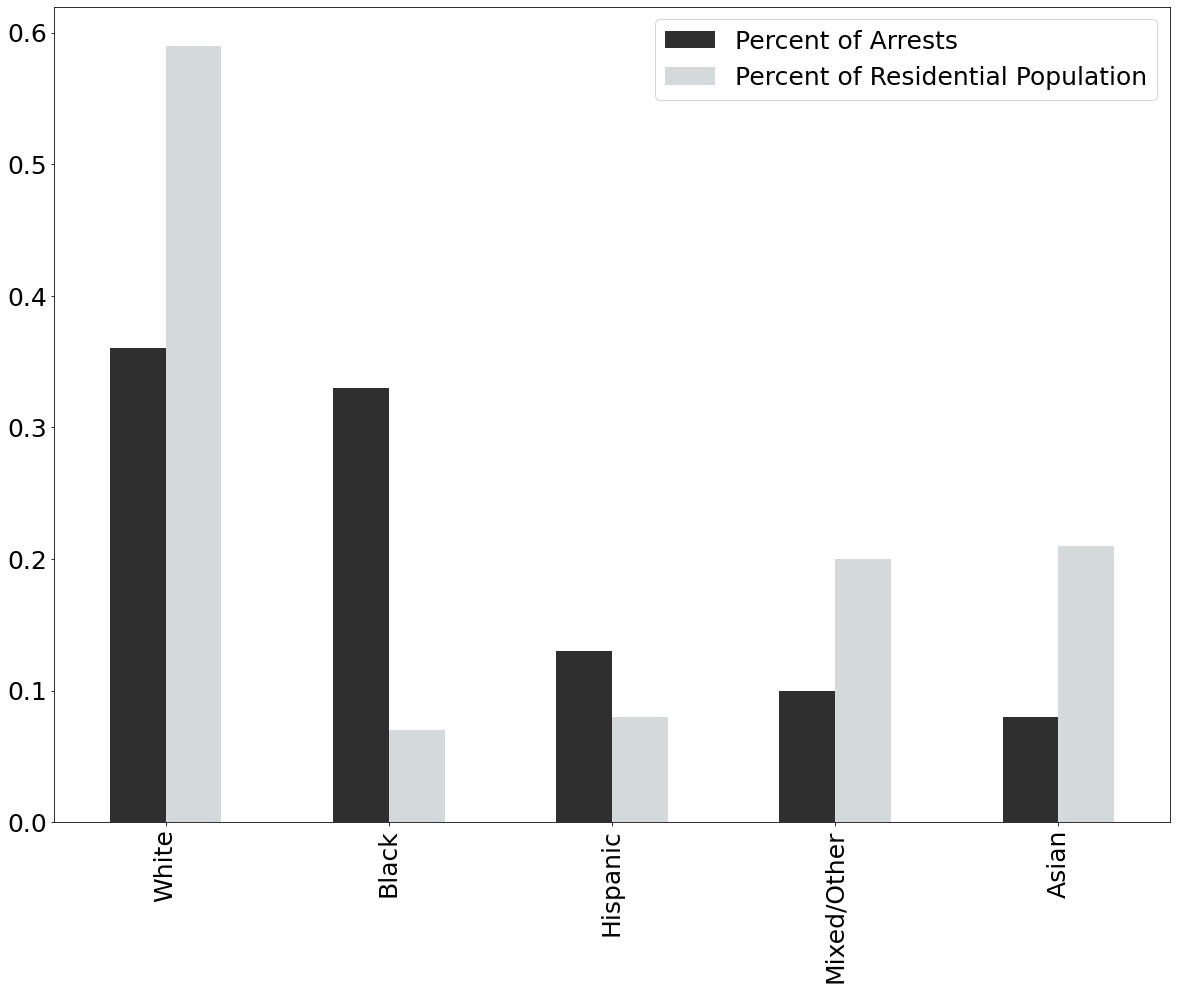

In [37]:
warnings.simplefilter("default")


plt.rc('font', size=25)

stops_grouped_chart = races_grouped.plot.bar(x='Race', y=['Percent of Arrests', 'Percent of Residential Population'], 
                                             legend=True, color=['#2F2F2F','#D4DADC'])
stops_grouped_chart.xaxis.set_label_text("")
figure = plt.gcf()
figure.set_size_inches(20, 15)
plt.savefig('Exports/Percent of Arrests vs Population')
plt.show()

In [38]:
warnings.filterwarnings("ignore")
small_dataset_boxplot = ripa_df_expanded[['Duration of Stop','Perceived Race or Ethnicity']]

small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 'White'] = 2
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 'Black/African American'] = 3
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] ==  'Black'] = 3
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity']=="Hispanic/Latino"] = 4 
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity']=="Hispanic"] = 4
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 'Asian'] = 5
small_dataset_boxplot['Perceived Race or Ethnicity'][~small_dataset_boxplot['Perceived Race or Ethnicity'].isin([2,3,4,5])] = 1


small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 1] = 'Mixed/Other'
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 2] = 'White'
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 3] = 'Black'
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity']== 4] = 'Hispanic'
small_dataset_boxplot['Perceived Race or Ethnicity'][small_dataset_boxplot['Perceived Race or Ethnicity'] == 5] = 'Asian'

# races = []
# for i in small_dataset_boxplot['Perceived Race or Ethnicity'].unique():
#     races.append(i)
races = ['Asian','Black','Hispanic','Mixed/Other','White']

<Figure size 1296x864 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7f05a18b5640>,
 'caps': [<matplotlib.lines.Line2D at 0x7f05a1917100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f05a18b51f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f05a18be2e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f05a18be670>,
 'means': []}

Text(0.5, 1.0, 'Average Duration of Stop by Race')

Text(0, 0.5, 'Duration')

([<matplotlib.axis.XTick at 0x7f05a1901a30>,
 [Text(1, 0, 'Asian'),
  Text(2, 0, 'Black'),
  Text(3, 0, 'Hispanic'),
  Text(4, 0, 'Mixed/Other'),
  Text(5, 0, 'White')])

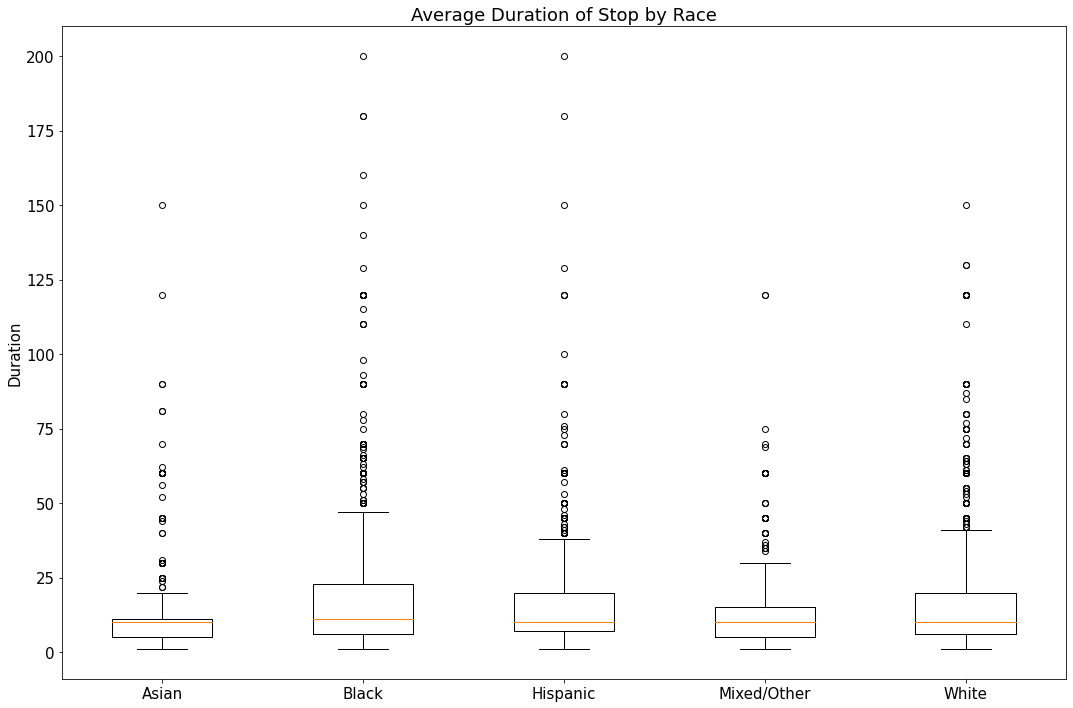

In [39]:
warnings.simplefilter("default")

small_dataset_boxplot = small_dataset_boxplot[small_dataset_boxplot['Duration of Stop'] <= 200]
box_arrayof_arrays = []
for race in races: 
    race_duration_array = small_dataset_boxplot[small_dataset_boxplot['Perceived Race or Ethnicity'] == race]['Duration of Stop']
    box_arrayof_arrays.append(race_duration_array)

    
plt.figure(figsize=(18, 12))
plt.rc('font', size=15)
duration = box_arrayof_arrays
plt.boxplot(duration)
plt.title('Average Duration of Stop by Race')
plt.ylabel('Duration')
plt.xticks(range(1, len(races) + 1), races);
plt.savefig('Exports/Average Duration of Stop by Race Boxplot')
plt.show()

### Creating Maps of the Data

In [40]:
from branca.colormap import linear
import branca.colormap
import folium.plugins # The Folium Javascript Map Library
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from folium import Choropleth
from folium.map import *
from collections import defaultdict
import geopandas

In [41]:
df = df_expanded
df_census_grouped = df.groupby('Census Tract')['Census Tract'].count().to_frame(name='Count')
berkeley = geopandas.read_file('Exports/Census Tract Polygons 2010 (EXPANDED).geojson')


tracts = df['Census Tract'].unique()
count_tracts = []
counts = []

for tract in tracts:
    table = df[df['Census Tract'] == tract]
    average_count = table.shape[0]
    count_tracts.append(tract)
    counts.append(average_count)
    
d = {'Census Tract':tracts, 'Count':counts}
counts_table = pd.DataFrame(data=d)
counts_table['Census Tract'] = counts_table['Census Tract'].astype(float)
counts_table.head(10)

,Census Tract,Count
0,4235.00,3486
1,4240.02,1705
2,4232.00,1344
3,4228.00,3407
4,4238.00,739
5,4237.00,1637
6,4239.02,878
7,4229.00,5985
8,4218.00,524
9,4220.00,11450


In [42]:
lat = df['LAT'].values 
lon = df['LONG'].values 

df_locs = np.vstack((lat, lon)).transpose().tolist() 


berk_coords = (37.8715, -122.2730)
berk_map = folium.Map(berk_coords, tiles='cartodbpositron', zoom_start=13.25)
heatmap = HeatMap(df_locs, name='Heatmap', radius = 13) 

# Add it to your Berkeley map.
heatmap.add_to(berk_map)

folium.Choropleth(
    geo_data = berkeley,
    name='Tract Boundaries',
    data = counts_table,
    columns=['Census Tract', 'Count'],
    line_weight=.25,
    fill_opacity=0,
    opacity=0,
    highlight=True,
).add_to(berk_map)
    
    

# Convert points to GeoJson
folium.features.GeoJson(berkeley,  
                        name='Tract Information',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.10, 'weight': 0.1},
                        tooltip=folium.features.GeoJsonTooltip( fields=['name10','totalpop','tract_annualstops','tract_medianincome','tract_whitepop','tract_aapop','tract_na_aipop','tract_asianpop','tract_hawaiianpop','tract_mixed2'],
                                                                aliases = ['Tract Name','Total Population','Annual Average Stops','Median Income','Number White Residents','Number African American Residents','Number Native American/American Indian Residents','Number Asian American Residents','Number Hawaiian Residents','Number Mixed Residents'],
                                                                labels=True,
                                                                sticky=False,
                                                                legend=False,
                                                                highlight=True
                                                                            )
                       ).add_to(berk_map)


steps=20
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(berk_map) #add color bar at the top of the map


folium.LayerControl(collapsed=False).add_to(berk_map)

file_path = r"Exports/Fullsize Heatmap.html"
berk_map.save(file_path) # Save as html file
berk_map

This following cell generates a really cool map with every individual incident - however it will slow down your notebook if you're only operating on the standard 1 GB of memory. If you'd like to try it, convert it from Raw NBconvert to code and run at your own risk. Have fun!

# Modelling

For this analysis, we perform a multiple logistic regression to determine the relationships of different variables to arrest and see how they increase/decrease odds of arrest, particularly regarding arrest. We've already removed and re-labeled most of the data's features above, and will create multi-stage models here to compare to eachother as well as observe likelihoods based on race. 

It is essentially the same scenario but with different race subjects: a traffic stop (with different races depending on models) in any tract of the city. This not only reveals how race affectslikelihood of arrest under similar conditions, but also if there are significant effects from tract variables in the first place. Race variables include the race of the person, but also the racial composition of the surrounding area (tract BIPOC composition) and if subject race had been perceived prior to the stop. The details of these models are discussed more in the project webpage. 

A breakdown of the model variables are shown here: 

#### RIPA and Non-RIPA Model Features: 
- Race (Categorical Option dependent on comparison)
- Perceived Age (Continuous Variable)
- Perceived Gender (Categorical Option 1, Male)
<br>
- Traffic Stop (Categorical Option 1, True)  
<br>

- Tract Distance from Cal (Continuous Variable)
- Tract Total Population (Continuous Variable)
- Tract Median Income (Continuous Variable)
- Tract Annual Average Stops (Continuous Variable)
- Tract BIPOC Composition (Continuous Variable)
<br>


#### RIPA Model Features: 
- Race (Categorical Option dependent on comparison)
- Perceived Age (Continuous Variable)
- Perceived Gender (Categorical Option 1, Male)
<br>
- Traffic Stop (Categorical Option 1, True)
- **Race perceived prior to stop (Categorical Option 1, True)**
<br>

- Tract Distance from Cal (Continuous Variable)
- Tract Total Population (Continuous Variable)
- Tract Median Income (Continuous Variable)
- Tract Annual Average Stops (Continuous Variable)
- Tract BIPOC Composition (Continuous Variable)

We include the additional variable of race perception in the smaller models because it is available in the RIPA-Compliant data. While these models are smaller, we'll find that they echo the racial disparities revealed in the broader models, and also highlight how significant the race perception variable is when documented. Credit to statsmodels for the computation packages and to [Andrew Villazon for his wonderful tutorial](https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#setting-a-reference-or-base-level-for-categorical-variables) on how to perform logistic regressions in python. 

The larger model is used to broadly observe if race has a significant relationship with arrest, and if so, how the odds of arrest vary by race. Of course the argument could be made that race was recorded but the arrest occured for other reasons, but the broad analysis is still important to see the overall pattern suggested by the CPE report. The existance of the disparities here also lays the foundation for the more detailed racial comparisons made in the smaller models.

In [43]:
import pandas as pd
import numpy as np
import warnings
import statistics as st 
import sys
import statsmodels.formula.api as smf


# Force display of all values 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [44]:
warnings.filterwarnings("ignore")

df = pd.read_csv('Exports/Large Dataset (with census data).csv')
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.lower()
df = df.iloc[:,1:]

df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] == 'White'] = 2
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] == 'Black/African American'] = 3
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] ==  'Black'] = 3
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] =="Hispanic/Latino"] = 4 
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] =="Hispanic"] = 4
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] == 'Asian'] = 5
df['perceivedraceorethnicity'][~df['perceivedraceorethnicity'].isin([2,3,4,5])] = 1



df['black'] = np.where(df['perceivedraceorethnicity'] == 3, 1,0)
np.where(df['black'] == 3, 0,0)
df['white'] = np.where(df['perceivedraceorethnicity'] == 2, 1,0)
np.where(df['white'] == 3, 0,0)
df['asian'] = np.where(df['perceivedraceorethnicity'] == 5, 1,0)
np.where(df['asian'] == 3, 0,0)
df['hispanic'] = np.where(df['perceivedraceorethnicity'] == 4, 1,0)
np.where(df['hispanic'] == 3, 0,0)


        
df['bipoc'] = np.where(df['perceivedraceorethnicity'] != 2, 1,0)
np.where(df['bipoc'] == 3, 0,0)

df['report_risk_groups'] = np.where(df['perceivedraceorethnicity'].isin([1,3,4]), 1,0)
df.report_risk_groups[df.report_risk_groups == 3] = 0





df.perceivedgender[df.perceivedgender == 'Male'] = 1
df.perceivedgender[df.perceivedgender == 'Female'] = 0
df[~df['perceivedgender'].isin([1,0])] = 3



df['resultofstop'] = df['resultofstop'].astype(str)
arrest = [df['resultofstop'][i] in ('Arrest') for i in range(df.index.size)]
df['arrest'] = arrest
df['arrest'][df['arrest']==False] = 0
df['arrest'][df['arrest']==True] = 1
df['arrest'] = df['arrest'].astype(int)



df['trafficstop'] = 0
df['trafficstop'][df['typeofstop'] == 'Vehicle'] = 1






df = df[(df['black'] != 3) & (df['white'] != 3) & (df['asian'] != 3) & (df['hispanic'] != 3)]
df['perceivedage'] = df['perceivedage'].apply(pd.to_numeric, errors='coerce')

df.drop(columns=['raceperceivedpriortostop','typeofstop','perceivedraceorethnicity','reasonforstop', 'reasonforstopnarrative', 
                 'resultofstop','lat', 'long', 'censustract','tract_na_aipop','tract_hawaiianpop', 'tract_mixed2',
                ], inplace=True)
df = df.astype(float)



df.to_csv('Exports/Coded Large DF.csv')

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
race_options = ['white','black','hispanic','asian','report_risk_groups','bipoc']


for race in race_options:
    formula = f"arrest ~ C({race}, Treatment(reference=0)) + perceivedage + C(perceivedgender, Treatment(reference=0)) + \
                C(trafficstop, Treatment(reference=0)) + tract_distancefromcal + tract_totalpop + tract_medianincome + tract_annualstops + tract_bipoccomp"
    log_reg = smf.logit(formula, data = df).fit()
    results = log_reg.summary()
    OR = pd.DataFrame(
        {
            "OR": log_reg.params,
            "Lower CI": log_reg.conf_int()[0],
            "Upper CI": log_reg.conf_int()[1],
        },
    )
    OR = np.exp(OR)
    
    print(f"\n\n{race} model (LARGE)\n{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n")

Optimization terminated successfully.
         Current function value: 0.166664
         Iterations 8


white model (LARGE)
                                                         OR  Lower CI  \
Intercept                                          0.182350  0.093687   
C(white, Treatment(reference=0))[T.1.0]            0.760497  0.698080   
C(perceivedgender, Treatment(reference=0))[T.1.0]  1.343391  1.217813   
C(trafficstop, Treatment(reference=0))[T.1.0]      0.163501  0.150674   
perceivedage                                       0.995739  0.992006   
tract_distancefromcal                              1.432525  1.281373   
tract_totalpop                                     1.000011  0.999984   
tract_medianincome                                 0.999996  0.999992   
tract_annualstops                                  0.999735  0.999612   
tract_bipoccomp                                    0.676795  0.307105   

                                                   Upper CI  
Intercept 

Here we'll do the same modelling, but exclusively with the expanded RIPA data. The following formula will also include a "race perceived prior to stop" variable. This is important not only because it's another racial variable, but because we can also observe how the prior perception of race affects the ORs of subject race and the local BIPOC composition. If the ouputted text isn't formatted properly, you can view the full models for both datasets [here](https://pastebin.com/0aG3qgyQ).

In [46]:
warnings.filterwarnings("ignore")

df = pd.read_csv('Exports/Small Dataset (with census data).csv')
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.lower()


df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] == 'White'] = 2
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] == 'Black/African American'] = 3
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] ==  'Black'] = 3
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] =="Hispanic/Latino"] = 4 
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] =="Hispanic"] = 4
df['perceivedraceorethnicity'][df['perceivedraceorethnicity'] == 'Asian'] = 5
df['perceivedraceorethnicity'][~df['perceivedraceorethnicity'].isin([2,3,4,5])] = 1



df['black'] = np.where(df['perceivedraceorethnicity'] == 3, 1,0)
np.where(df['black'] == 3, 0,0)
df['white'] = np.where(df['perceivedraceorethnicity'] == 2, 1,0)
np.where(df['white'] == 3, 0,0)
df['asian'] = np.where(df['perceivedraceorethnicity'] == 5, 1,0)
np.where(df['asian'] == 3, 0,0)
df['hispanic'] = np.where(df['perceivedraceorethnicity'] == 4, 1,0)
np.where(df['hispanic'] == 3, 0,0)


        
df['bipoc'] = np.where(df['perceivedraceorethnicity'] != 2, 1,0)
np.where(df['bipoc'] == 3, 0,0)

df['report_risk_groups'] = np.where(df['perceivedraceorethnicity'].isin([1,3,4]), 1,0)
df.report_risk_groups[df.report_risk_groups == 3] = 0





df.perceivedgender[df.perceivedgender == 'Male'] = 1
df.perceivedgender[df.perceivedgender == 'Female'] = 0
df[~df['perceivedgender'].isin([1,0])] = 3



df['resultofstop'] = df['resultofstop'].astype(str)
arrest = [df['resultofstop'][i] in ('Arrest') for i in range(df.index.size)]
df['arrest'] = arrest
df['arrest'][df['arrest']==False] = 0
df['arrest'][df['arrest']==True] = 1
df['arrest'] = df['arrest'].astype(int)



df['trafficstop'] = 0
df['trafficstop'][df['typeofstop'] == 'Vehicle'] = 1


df['raceperceivedpriortostop'] = np.where(df['raceperceivedpriortostop']==True, 1,0)




df = df[(df['black'] != 3) & (df['white'] != 3) & (df['asian'] != 3) & (df['hispanic'] != 3)]
df['perceivedage'] = df['perceivedage'].apply(pd.to_numeric, errors='coerce')

df.drop(columns=['typeofstop','perceivedraceorethnicity','reasonforstop', 
                 'resultofstop','lat', 'long', 'censustract','tract_na_aipop','tract_hawaiianpop', 'tract_mixed2',
                ], inplace=True)
df = df.astype(float)




df.to_csv('Exports/Coded Small DF.csv')

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
race_options = ['white','black','hispanic','asian','report_risk_groups','bipoc']


for race in race_options:
    formula = f"arrest ~ C({race}, Treatment(reference=0)) + perceivedage + C(perceivedgender, Treatment(reference=0)) + \
                C(trafficstop, Treatment(reference=0)) + C(raceperceivedpriortostop, Treatment(reference=0)) + \
                tract_distancefromcal + tract_totalpop + tract_medianincome + tract_annualstops + tract_bipoccomp"
    log_reg = smf.logit(formula, data = df).fit()
    results = log_reg.summary()
    OR = pd.DataFrame(
        {
            "OR": log_reg.params,
            "Lower CI": log_reg.conf_int()[0],
            "Upper CI": log_reg.conf_int()[1],
        },
    )
    OR = np.exp(OR)
    
    print(f"\n\n{race} model (SMALL)\n{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n")

Optimization terminated successfully.
         Current function value: 0.327381
         Iterations 7


white model (SMALL)
                                                          OR  Lower CI  \
Intercept                                           0.047913  0.016234   
C(white, Treatment(reference=0))[T.1.0]             0.851114  0.732561   
C(perceivedgender, Treatment(reference=0))[T.1.0]   1.589029  1.318305   
C(trafficstop, Treatment(reference=0))[T.1.0]       0.238957  0.197722   
C(raceperceivedpriortostop, Treatment(reference...  1.475667  1.243552   
perceivedage                                        0.996491  0.990931   
tract_distancefromcal                               1.095086  0.911518   
tract_totalpop                                      1.000002  0.999956   
tract_medianincome                                  1.000006  1.000001   
tract_annualstops                                   0.999608  0.999375   
tract_bipoccomp                                     3.997550  

# Discussion

In the larger model, we found that all of the race categories had a significant or very significant relationship with arrest, and that white odds of arrest were lower than BIPOC categories odds. Being black had the highest odds increase in likelihood of arrest at approximately 1.46x, while being White lowered odds of arrest at .76x. In logistic regression models OR (Odds Ratio) values of <1 mean less likely and OR values of >1 mean more likely. In this case, the OR values just based on race already suggest that being Black substantially increases your odds of arrest, while being White substantially decreases them. The broader BIPOC variable also had an OR of 1.31x, indicating that just not being white increases odds of arrest. Asians are included in this category, however it's worth noting the Asian variable on it's own had a .80x OR, and as seen earlier had very different stop durations as well. The other racial variable, tract BIPOC composition, did not have a significant relationship with arrest in any of the other models, meanining it did not have a clear relationship with arrest and did not affect it. All other tract variables besides tract_distancefromcal were either insignificant, or did not cause large increases or decreases in odds of arrest. Ultimately the initial patterns here suggest that local variables largely don't matter, but race variables do. With the scale of results, these are valuable insights.

The smaller model echoed some of these patterns, as well as revealed just how important other just how important officer perception of race is. Under the condition that the officer had perceived the race of the subject prior to the stop, almost every race category except Hispanic had a significant or very significant relationship with arrest. Interestingly, the perception variable noticeably affected the ORs for previous high or low race categories: being White had a slightly higher OR or .85x, and being Black had a slightly lower OR of .12x, while being BIPOC lowered to 1.17x and being Asian drastically lowered to .49x. The perception variable itself was consistently very significant, and had a high OR increase that hovered at between 1.44x-1.48x. The biggest difference however was in the relevance of the local racial composition - the tract BIPOC composition variable was very significant in every model, and had the highest OR increase of any variable, remaining at approximately 4x in every scenario. The confidence interval for this variable was also extremely large compared to the previous larger models, with lower CIs as low as 1.09x and upper CIs as high as 15x. This could indicate a few things: the data for it could be innacurate somehow, or that the variable is both very important and very uncertain depending on the officer's perception. No matter what, it's importance changed when prior perception of race was included in the model, signalling again that racial factors do play a key role in decisions of arrest. 

Other tract variables were again either insignificant or did not have notable changes on the odds of arrest. 

Overall, there is a clear pattern between both datasets: that while local variables may not have much affect on the odds of arrest, race variables do increase the likelihood of arrest for BIPOC subjects and decrease them for White subjects. On top of this, if your race is perceived prior to the stop you are more likely to be arrested, and the officer is more likely to seriously weigh in how white the surrounding neighborhood is in deciding to arrest. While it might not be appropriate to say that this look into stops data necessary shows a form of causation, it is appropriate to say that race does play a role in arrests in Berkeley, and not in a good way. 

We've also seen just how important the new racial features provided by RIPA-compliant data can be in analysis of the data. The CPE's pre-existing requests for more comprehensive data in future analysis have proved useful here: the perception of race variable alone both affected the likelihood of arrest significantly, but also how other racial features were factored in. 

It's our hope that the analysis done here both proved the points of the CPE before there were substantial changes in the data, and also set up a baseline of likelihoods within RIPA-compliant data to observe how policy changes in berkeley impact stop subjects in the future. It will be interesting to continue analysis of the data as Berkeley moves into a drastically different municipal space, and to see what the data looks like as we move out of COVID-19. Thanks for participating!